In [1]:
import tensorflow as tf
print(f"Num Gpu Avaiable Are : {len(tf.config.list_physical_devices('GPU'))}")

Num Gpu Avaiable Are : 1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import cv2
import os, glob
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D,GlobalAveragePooling2D,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, LSTM
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [3]:
data_train = r"./dataset/train"
data_test = r"./dataset/test"
fake=[]
for file in os.listdir(data_test):
    if file[0] =='.':
        continue
    fake+=[file]
print(fake)
print(len(fake))
# for file1 in os.listdir(data_train):
#     if file1[0] =='.':
#         continue
#     fake+=[file1]
# print(fake)
# print(len(fake))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


In [4]:
img_height,img_width=256,256
batch_size=20

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(data_train,
                                                target_size=(img_height,img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                               )
test_generator = train_datagen.flow_from_directory(data_test,
                                                target_size=(img_height,img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                               
                                               )

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [5]:
precision=tf.keras.metrics.Precision()
recall=tf.keras.metrics.Recall()
sensitivity=tf.keras.metrics.SensitivityAtSpecificity(0.1)
specificity=tf.keras.metrics.SpecificityAtSensitivity(0.1)

In [6]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## HYBRID_MODEL(LSTM+MOBILENET)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, LSTM, Reshape

# Initialize a Sequential model
model = Sequential()

# Add Convolutional layers
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(img_height, img_width, 3)))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# Flatten the output from CNN layers
model.add(Flatten())

# Reshape the flattened output to have the correct number of timesteps
model.add(Reshape((128, 2048)))  # Adjust the shape based on your data

# Add LSTM layers
model.add(LSTM(128, return_sequences=True))  # You can adjust the number of LSTM units as needed
model.add(LSTM(64, return_sequences=True))   # You can adjust the number of LSTM units as needed
model.add(LSTM(32, return_sequences=True))   # Adding one more LSTM layer
model.add(LSTM(16, return_sequences=True))   # Adding another LSTM layer

# Add a Dense layer
model.add(Dense(256, activation="relu"))

# Output layer
model.add(Dense(9, activation="softmax"))

# Display the model summary
model.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 256, 256, 32)      2432      
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 256, 256, 32)      25632     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 262144)           

In [22]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy',precision,recall,sensitivity,specificity])
hist=model.fit(train_generator,epochs=50,validation_data=test_generator)


Epoch 1/50


ValueError: in user code:

    c:\Users\0258\.conda\envs\deepfake\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    c:\Users\0258\.conda\envs\deepfake\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\Users\0258\.conda\envs\deepfake\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\Users\0258\.conda\envs\deepfake\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\Users\0258\.conda\envs\deepfake\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\Users\0258\.conda\envs\deepfake\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    c:\Users\0258\.conda\envs\deepfake\lib\site-packages\keras\engine\training.py:789 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    c:\Users\0258\.conda\envs\deepfake\lib\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    c:\Users\0258\.conda\envs\deepfake\lib\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    c:\Users\0258\.conda\envs\deepfake\lib\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    c:\Users\0258\.conda\envs\deepfake\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    c:\Users\0258\.conda\envs\deepfake\lib\site-packages\keras\losses.py:1666 categorical_crossentropy
        y_true, y_pred, from_logits=from_logits, axis=axis)
    c:\Users\0258\.conda\envs\deepfake\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    c:\Users\0258\.conda\envs\deepfake\lib\site-packages\keras\backend.py:4839 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    c:\Users\0258\.conda\envs\deepfake\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, None) and (None, 128, 9) are incompatible


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, LSTM, Reshape,MaxPooling2D

# Initialize a Sequential model
model = Sequential()

# Add Convolutional layers
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(img_height, img_width, 3)))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# Flatten the output from CNN layers
model.add(Flatten())

# Reshape the flattened output to have the correct number of timesteps
model.add(Reshape((128, 2048)))  # Adjust the shape based on your data

# Add LSTM layers
model.add(LSTM(128, return_sequences=True))  # You can adjust the number of LSTM units as needed
model.add(LSTM(64, return_sequences=True))   # You can adjust the number of LSTM units as needed
model.add(LSTM(32, return_sequences=True))   # Adding one more LSTM layer
model.add(LSTM(16, return_sequences=True))   # Adding another LSTM layer

# Add a Dense layer
model.add(Dense(256, activation="relu"))

# Output layer for 9-class classification
model.add(Dense(9, activation="softmax"))

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy', precision, recall, sensitivity, specificity])


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, LSTM, Reshape,MaxPooling2D
input_shape = (64, 64, 3)
model = Sequential()
# Convolutional layers for spatial feature extraction
model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Global Average Pooling to reduce spatial dimensions
model.add(GlobalAveragePooling2D())
# Reshape to 3D tensor (batch_size, timesteps, input_features)
model.add(Reshape((1, -1)))
# LSTM layer for capturing temporal dependencies
model.add(LSTM(128, activation='relu'))
# Dense layers for classification
model.add(Dense(64, activation='relu'))
model.add(Dense(9, activation='softmax'))  # Assuming 2 classes
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Display the model summary
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 1, 64)             0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)             

In [26]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',precision,recall,sensitivity,specificity])
hist=model.fit(train_generator,epochs=50,validation_data=test_generator)

Epoch 1/50
112/112 [==============================] - 189s 2s/step - loss: 2.0639 - accuracy: 0.1822 - precision: 0.0000e+00 - recall: 0.0000e+00 - sensitivity_at_specificity: 0.9607 - specificity_at_sensitivity: 0.9342 - val_loss: 2.2661 - val_accuracy: 0.1356 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_sensitivity_at_specificity: 0.9661 - val_specificity_at_sensitivity: 0.9280
Epoch 2/50
112/112 [==============================] - 171s 2s/step - loss: 2.0308 - accuracy: 0.2072 - precision: 0.0000e+00 - recall: 0.0000e+00 - sensitivity_at_specificity: 0.9433 - specificity_at_sensitivity: 0.9296 - val_loss: 2.2236 - val_accuracy: 0.1271 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_sensitivity_at_specificity: 0.8898 - val_specificity_at_sensitivity: 0.8930
Epoch 3/50
112/112 [==============================] - 184s 2s/step - loss: 2.0239 - accuracy: 0.2054 - precision: 0.0000e+00 - recall: 0.0000e+00 - sensitivity_at_specificity: 0.9661 - specificity_at_sensit

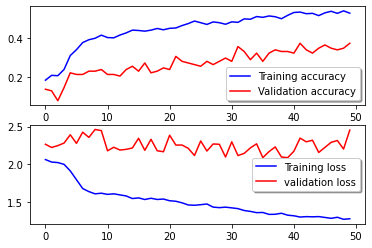

In [27]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

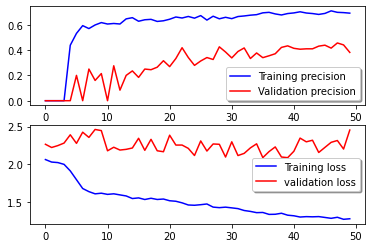

In [28]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['precision'], color='b', label="Training precision")
ax[0].plot(hist.history['val_precision'], color='r',label="Validation precision")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

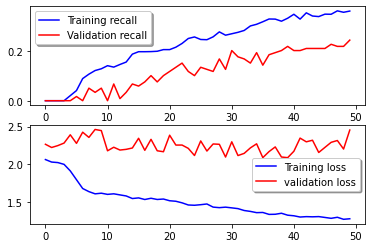

In [29]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['recall'], color='b', label="Training recall")
ax[0].plot(hist.history['val_recall'], color='r',label="Validation recall")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

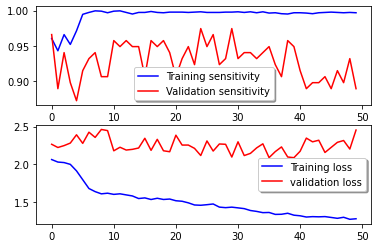

In [30]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['sensitivity_at_specificity'], color='b', label="Training sensitivity")
ax[0].plot(hist.history['val_sensitivity_at_specificity'], color='r',label="Validation sensitivity")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

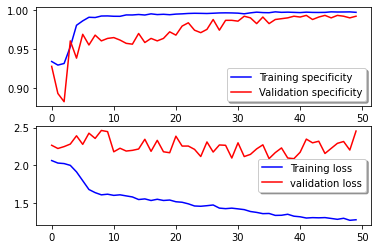

In [31]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['specificity_at_sensitivity'], color='b', label="Training specificity")
ax[0].plot(hist.history['val_specificity_at_sensitivity'], color='r',label="Validation specificity")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

In [32]:
model.save("./models/LSTM.h5")

In [33]:
filenames = test_generator.filenames
nb_samples = len(filenames)
model_predict = model.predict_generator(test_generator,steps = nb_samples, verbose=2)

c:\Users\0258\.conda\envs\deepfake\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


118/118 - 9s


Confusion matrix, without normalization
[[0 4 1 0 6 3 0 1 1]
 [0 7 1 1 3 3 0 1 0]
 [0 3 0 1 3 6 0 2 1]
 [0 4 0 5 3 3 0 1 0]
 [0 5 1 3 2 2 0 2 1]
 [0 5 0 3 6 2 0 0 0]
 [0 1 1 0 1 0 0 0 0]
 [0 3 0 1 8 4 0 0 0]
 [0 1 0 0 1 1 0 0 0]]


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

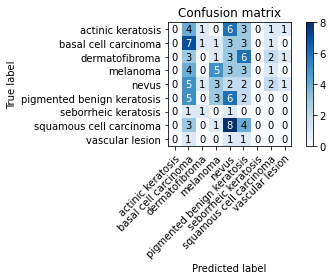

In [35]:
y_true = test_generator.classes
y_pred = model_predict.argmax(axis=1)
plot_confusion_matrix(y_true, y_pred, classes=['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'],
                      title='Confusion matrix')

## MOBILENET

In [7]:
base_model = tf.keras.applications.MobileNet(input_shape=(img_height,img_width, 3), include_top=False,
                          weights='imagenet')
model8 = Sequential()
model8.add(base_model)
model8.add(GlobalAveragePooling2D())
model8.add(Dense(1024, activation='relu'))
model8.add(Dense(512, activation='relu'))
model8.add(Dense(256, activation='relu'))
model8.add(Dense(128, activation='relu'))
model8.add(Dense(64, activation='relu'))
model8.add(BatchNormalization())
model8.add(Dropout(0.2))
model8.add(Dense(9, activation='sigmoid'))
model8.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 8, 8, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8

In [8]:
model8.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy',precision,recall,sensitivity,specificity])
hist8=model8.fit(train_generator,epochs=50,validation_data=test_generator)
model8.save("./models/mobilenet.h5")


Epoch 1/50
112/112 [==============================] - 79s 589ms/step - loss: 1.6138 - accuracy: 0.4640 - precision: 0.1982 - recall: 0.8267 - sensitivity_at_specificity: 0.9902 - specificity_at_sensitivity: 0.9922 - val_loss: 5.3179 - val_accuracy: 0.2203 - val_precision: 0.1336 - val_recall: 0.5085 - val_sensitivity_at_specificity: 0.9492 - val_specificity_at_sensitivity: 0.9650
Epoch 2/50
112/112 [==============================] - 42s 372ms/step - loss: 1.0951 - accuracy: 0.6498 - precision: 0.2451 - recall: 0.9410 - sensitivity_at_specificity: 0.9987 - specificity_at_sensitivity: 0.9972 - val_loss: 2.0465 - val_accuracy: 0.3814 - val_precision: 0.1968 - val_recall: 0.8390 - val_sensitivity_at_specificity: 1.0000 - val_specificity_at_sensitivity: 0.9788
Epoch 3/50
112/112 [==============================] - 42s 374ms/step - loss: 0.8467 - accuracy: 0.7249 - precision: 0.2634 - recall: 0.9696 - sensitivity_at_specificity: 1.0000 - specificity_at_sensitivity: 0.9984 - val_loss: 3.5128 -

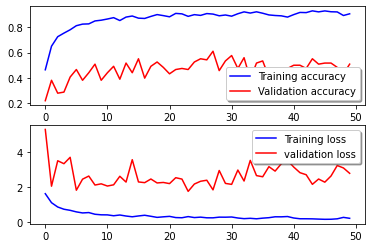

In [9]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist8.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(hist8.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist8.history['loss'], color='b', label="Training loss")
ax[1].plot(hist8.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)

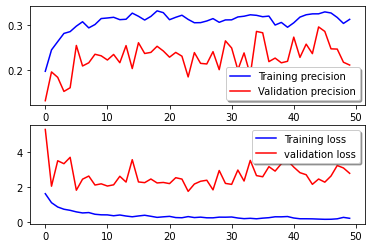

In [10]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist8.history['precision'], color='b', label="Training precision")
ax[0].plot(hist8.history['val_precision'], color='r',label="Validation precision")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist8.history['loss'], color='b', label="Training loss")
ax[1].plot(hist8.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)

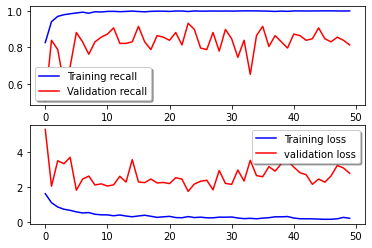

In [11]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist8.history['recall'], color='b', label="Training recall")
ax[0].plot(hist8.history['val_recall'], color='r',label="Validation recall")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist8.history['loss'], color='b', label="Training loss")
ax[1].plot(hist8.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)

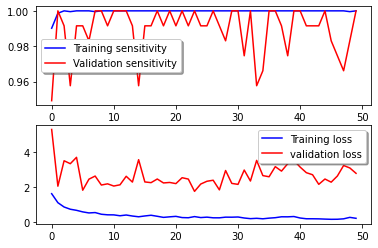

In [12]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist8.history['sensitivity_at_specificity'], color='b', label="Training sensitivity")
ax[0].plot(hist8.history['val_sensitivity_at_specificity'], color='r',label="Validation sensitivity")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist8.history['loss'], color='b', label="Training loss")
ax[1].plot(hist8.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)

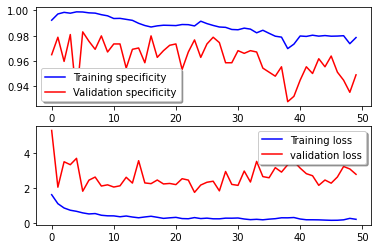

In [13]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist8.history['specificity_at_sensitivity'], color='b', label="Training specificity")
ax[0].plot(hist8.history['val_specificity_at_sensitivity'], color='r',label="Validation specificity")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist8.history['loss'], color='b', label="Training loss")
ax[1].plot(hist8.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)

In [15]:
filenames = test_generator.filenames
nb_samples = len(filenames)
model1_predict = model8.predict_generator(test_generator,steps = nb_samples, verbose=2)

c:\Users\0258\.conda\envs\deepfake\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


118/118 - 8s


Confusion matrix, without normalization
[[1 3 0 0 5 3 0 3 1]
 [2 2 1 3 6 1 0 1 0]
 [1 2 1 3 3 4 0 2 0]
 [2 1 3 1 5 4 0 0 0]
 [3 0 1 1 5 4 0 2 0]
 [1 1 2 0 1 6 0 4 1]
 [0 0 0 1 1 1 0 0 0]
 [2 2 1 0 8 2 0 0 1]
 [0 0 1 1 0 1 0 0 0]]


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

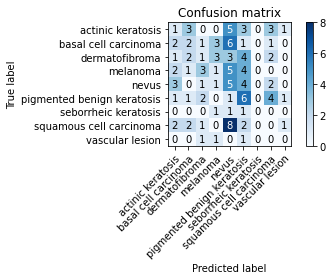

In [17]:
y_true = test_generator.classes
y_pred = model1_predict.argmax(axis=1)
plot_confusion_matrix(y_true, y_pred, classes=['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'],
                      title='Confusion matrix')

In [19]:
##CNN

In [21]:
model2 = Sequential()

model2.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (img_height,img_width,3)))
model2.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))


model2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model2.add(Flatten())
model2.add(Dense(256, activation = "relu"))

model2.add(Dense(9, activation = "softmax"))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 32)      2432      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 32)      25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 262144)           

In [22]:
model2.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy',precision,recall,sensitivity,specificity])
hist=model2.fit(train_generator,epochs=50,validation_data=test_generator)

Epoch 1/50
112/112 [==============================] - 59s 479ms/step - loss: 2.1813 - accuracy: 0.1979 - precision: 0.2164 - recall: 0.0471 - sensitivity_at_specificity: 0.9508 - specificity_at_sensitivity: 0.9447 - val_loss: 2.3230 - val_accuracy: 0.1356 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_sensitivity_at_specificity: 0.8390 - val_specificity_at_sensitivity: 0.8909
Epoch 2/50
112/112 [==============================] - 48s 432ms/step - loss: 1.9688 - accuracy: 0.2269 - precision: 0.8462 - recall: 0.0295 - sensitivity_at_specificity: 0.9705 - specificity_at_sensitivity: 0.9616 - val_loss: 2.4564 - val_accuracy: 0.1525 - val_precision: 0.1333 - val_recall: 0.0169 - val_sensitivity_at_specificity: 0.9746 - val_specificity_at_sensitivity: 0.8941
Epoch 3/50
112/112 [==============================] - 48s 426ms/step - loss: 1.9809 - accuracy: 0.2461 - precision: 0.7348 - recall: 0.0433 - sensitivity_at_specificity: 0.9692 - specificity_at_sensitivity: 0.9700 - val_loss: 

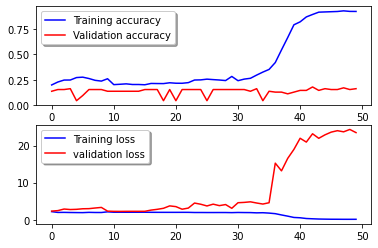

In [23]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

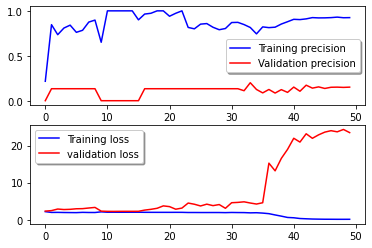

In [24]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['precision'], color='b', label="Training precision")
ax[0].plot(hist.history['val_precision'], color='r',label="Validation precision")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

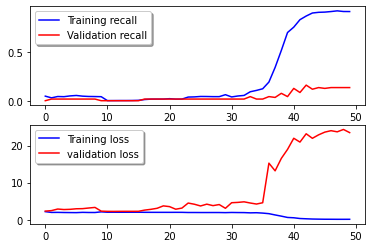

In [25]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['recall'], color='b', label="Training recall")
ax[0].plot(hist.history['val_recall'], color='r',label="Validation recall")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

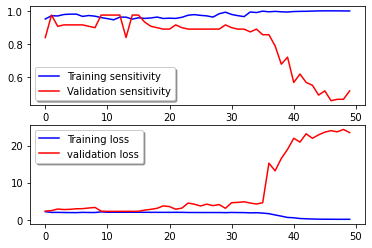

In [26]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['sensitivity_at_specificity'], color='b', label="Training sensitivity")
ax[0].plot(hist.history['val_sensitivity_at_specificity'], color='r',label="Validation sensitivity")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

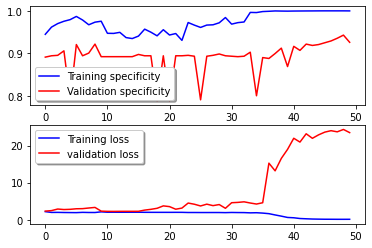

In [27]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['specificity_at_sensitivity'], color='b', label="Training specificity")
ax[0].plot(hist.history['val_specificity_at_sensitivity'], color='r',label="Validation specificity")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

In [28]:
model.save("./models/CNN.h5")

In [29]:
filenames = test_generator.filenames
nb_samples = len(filenames)
model_predict = model.predict_generator(test_generator,steps = nb_samples, verbose=2)

c:\Users\0258\.conda\envs\deepfake\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


118/118 - 9s


Confusion matrix, without normalization
[[ 0  0  7  0  0  0  8  0  1]
 [ 0  0  9  0  0  0  5  0  2]
 [ 0  0  4  0  0  0  9  0  3]
 [ 0  0  6  0  0  0  8  0  2]
 [ 0  0  3  0  0  0 12  0  1]
 [ 0  0  4  0  0  0 10  0  2]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  5  0  0  0  9  0  2]
 [ 0  0  0  0  0  0  2  0  1]]


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

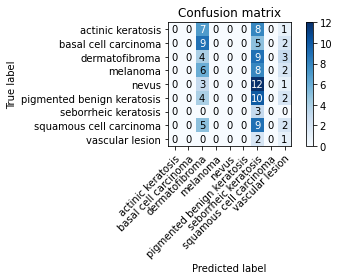

In [30]:
y_true = test_generator.classes
y_pred = model_predict.argmax(axis=1)
plot_confusion_matrix(y_true, y_pred, classes=['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'],
                      title='Confusion matrix')